<a href="https://colab.research.google.com/github/sambhav-antriksh/Fourier_Neural_Network/blob/main/Vorticity_2D_FNO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install equinox

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import random
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
import matplotlib.pyplot as plt
from typing import Callable, List
import scipy
from tqdm.autonotebook import tqdm
from typing import Callable, List
import scipy
from tqdm.autonotebook import tqdm,trange
from tqdm import trange

In [ ]:
data_path='combined_NS_T2_samples_10k.npz'


In [ ]:
data=np.load(data_path)

In [ ]:
a_np=data['a']
u_np=data['u']

In [ ]:
print(f'Loaded dataset: a.shape={a_np.shape}, u.shape={u_np.shape}')

Loaded dataset: a.shape=(10000, 64, 64), u.shape=(10000, 64, 64)


In [ ]:
print(f"a range: ({a_np.min():.3f}, {a_np.max():.3f}), mean={a_np.mean():.3f}")
print(f"u range: ({u_np.min():.3f}, {u_np.max():.3f}), mean={u_np.mean():.3f}")

a range: (-4.734, 4.913), mean=-0.000
u range: (-4.656, 4.837), mean=-0.000


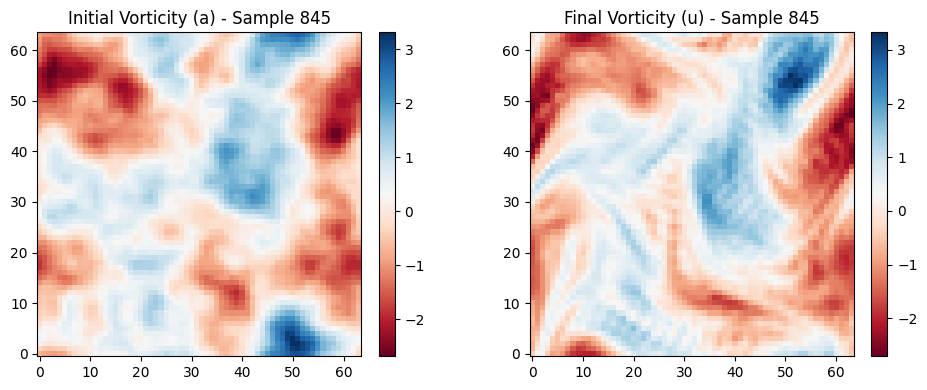

In [ ]:
sample_idx=845
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

im0 = axes[0].imshow(a_np[sample_idx], cmap='RdBu', origin='lower')
axes[0].set_title(f"Initial Vorticity (a) - Sample {sample_idx}")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(u_np[sample_idx], cmap='RdBu', origin='lower')
axes[1].set_title(f"Final Vorticity (u) - Sample {sample_idx}")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================
# DATA LOADING
# ============================================================
import numpy as np

# Load combined dataset (a: initial, u: final vorticity)
data = np.load("combined_NS_T2_samples_10k.npz")
a_np = data["a"]    # shape (1000, 64, 64)
u_np = data["u"]    # shape (1000, 64, 64)

baseline_mse = np.mean((a_np - u_np)**2)
print(f"Baseline MSE between a and u: {baseline_mse:.5e}")
# Convert to JAX arrays and add channel dimension (C=1)
a = jnp.expand_dims(jnp.array(a_np), axis=-1)  # (1000, 64, 64, 1)
u = jnp.expand_dims(jnp.array(u_np), axis=-1)  # (1000, 64, 64, 1)

print("a.shape:", a.shape, "u.shape:", u.shape)


Baseline MSE between a and u: 8.59064e-01
a.shape: (10000, 64, 64, 1) u.shape: (10000, 64, 64, 1)


MSE for sample 0 (a_np[0] - u_np[0]): 4.79280e-01
Max absolute difference for sample 0: 2.32128e+00


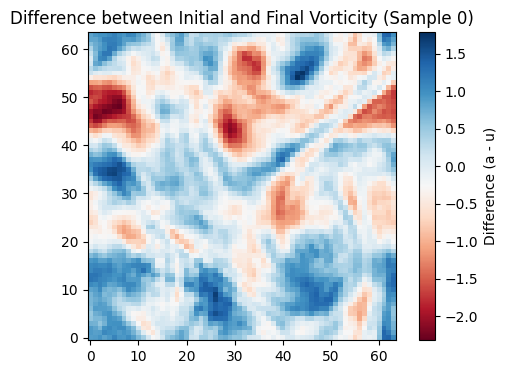

In [ ]:
import numpy as np
data = np.load("combined_NS_T2_samples_10k.npz")
a_np = data["a"]  # (1000, 64, 64)
u_np = data["u"]  # (1000, 64, 64)

# MSE for sample 0
sample_mse = np.mean((a_np[0] - u_np[0])**2)
print(f"MSE for sample 0 (a_np[0] - u_np[0]): {sample_mse:.5e}")

# Max absolute difference for sample 0
max_diff = np.max(np.abs(a_np[0] - u_np[0]))
print(f"Max absolute difference for sample 0: {max_diff:.5e}")

# Plot with colorbar to see scale
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
im = plt.imshow(a_np[0] - u_np[0], cmap='RdBu', origin='lower')
plt.colorbar(im, label="Difference (a - u)")
plt.title("Difference between Initial and Final Vorticity (Sample 0)")
plt.show()

In [ ]:
# Convert from (B, H, W, C) → (B, C, H, W)
a = jnp.transpose(a, (0, 3, 1, 2))
u = jnp.transpose(u, (0, 3, 1, 2))


In [ ]:
mean_all = jnp.concatenate([a.flatten(), u.flatten()]).mean()
std_all  = jnp.concatenate([a.flatten(), u.flatten()]).std()
a = (a - mean_all) / std_all
u = (u - mean_all) / std_all


In [ ]:
# Split into train and test
train_x = a[:8000]      # first 800 samples for training
test_x  = a[8000:]      # last 200 samples for testing

train_y = u[:8000]
test_y  = u[8000:]

print(train_x.shape, test_x.shape)
print(train_y.shape, test_y.shape)


(8000, 1, 64, 64) (2000, 1, 64, 64)
(8000, 1, 64, 64) (2000, 1, 64, 64)


In [ ]:
class SpectralConv2d(eqx.Module):
    real_weights: jax.Array
    imag_weights: jax.Array
    in_channels: int
    out_channels: int
    modes1: int
    modes2: int

    def __init__(self,in_channels,out_channels,modes1,modes2,*,key):
        self.in_channels=in_channels
        self.out_channels=out_channels
        self.modes1=modes1
        self.modes2=modes2

        scale=1.0/(in_channels*out_channels)
        key_r,key_i=jax.random.split(key)
        self.real_weights=jax.random.uniform(key_r,(in_channels,out_channels,modes1,modes2),minval=-scale,maxval=scale)
        self.imag_weights=jax.random.uniform(key_i,(in_channels,out_channels,modes1,modes2),minval=-scale,maxval=scale)

    def complex_multiply2d(self, x_hat, w):
        # x_hat: ( in_c, H, W)
        # w: (in_c, out_c, m1, m2)
        return jnp.einsum("ixy,ioxy->oxy", x_hat, w)

    def __call__(self,x,):
            ''' jnp.ndarray of shape(in_channels,H,W) returns: jnp.ndarray of shape(out_channels,H,W)'''
            in_channels,H,W=x.shape
            x_ft=jnp.fft.rfft2(x)  #(in_c,H,W//2)
            Wc=x_ft.shape[-1]


            x_ft=jnp.fft.rfft2(x)  #(in_c,H,W//2)
            Wc=x_ft.shape[-1]

            weights = self.real_weights + 1j * self.imag_weights

            out_ft = jnp.zeros((self.out_channels, H, Wc), dtype=jnp.complex64)

            out_ft = out_ft.at[:, :self.modes1, :self.modes2].set(
            self.complex_multiply2d(x_ft[:, :self.modes1, :self.modes2], weights))

            out = jnp.fft.irfft2(out_ft, s=(H, W))

            return out # shape(out_channels,H,W)


In [ ]:
class FNOBlock2d(eqx.Module):
    spectral_conv: SpectralConv2d
    bypass_conv: eqx.nn.Conv2d
    activation: Callable

    def __init__(self,in_channels,out_channels,modes1,modes2,activation,*,key):
        spec_key,bypass_key=jax.random.split(key)
        self.spectral_conv=SpectralConv2d(in_channels,out_channels,modes1,modes2,key=spec_key)

        # 1*1 convolution for local linear mixing(bypass)

        self.bypass_conv= eqx.nn.Conv2d(in_channels,out_channels,kernel_size=1,key=bypass_key)

        self.activation=activation

    def __call__(self,x,):
        ''' x: (in_channels,H,W) returns; (out_channels,H,W)'''

        y=self.spectral_conv(x)
        z=self.bypass_conv(x)

        return self.activation(y+z)

In [ ]:
class FNO2D(eqx.Module):
    lifting:eqx.nn.Conv2d
    fno_blocks:List[FNOBlock2d]
    projection: eqx.nn.Conv2d

    def __init__(self,in_channels,out_channels,modes1,modes2,width,activation,n_blocks=4,*,key):
         key, lifting_key = jax.random.split(key)
         # Lifting layer — project input channels to higher-dimensional latent space
         self.lifting = eqx.nn.Conv2d(
            in_channels=in_channels,
            out_channels=width,
            kernel_size=(1, 1),
            key=lifting_key)
         # Stack of FNO blocks
         self.fno_blocks = []
         for _ in range(n_blocks):
            key, subkey = jax.random.split(key)
            block = FNOBlock2d(
                in_channels=width,
                out_channels=width,
                modes1=modes1,
                modes2=modes2,
                activation=activation,
                key=subkey,
            )
            self.fno_blocks.append(block)

        # Projection layer — map back to target channels
         key, projection_key = jax.random.split(key)
         self.projection = eqx.nn.Conv2d(
            in_channels=width,
            out_channels=out_channels,
            kernel_size=(1, 1),
            key=projection_key,)

    def __call__(self, x):
        """
        x: (in_channels, H, W)
        output: (out_channels, H, W)
        """
        # Lifting to higher feature space
        x = self.lifting(x)

        # Sequential FNO blocks
        for fno_block in self.fno_blocks:
            x = fno_block(x)

        # Project back to desired output channels
        x = self.projection(x)

        return x


In [ ]:
key = jax.random.PRNGKey(0)
fno = FNO2D(
    in_channels=1,        # one input field (a)
    out_channels=1,       # one output field (u)
    modes1=8,            # number of Fourier modes in x-direction
    modes2=8,            # number of Fourier modes in y-direction
    width=16,             # hidden channel width (like in FNO1D)
    activation=jax.nn.relu,
    n_blocks=4,
    key=key,
)


In [ ]:
def dataloader(key, dataset_x, dataset_y, batch_size):
    n_samples = dataset_x.shape[0]
    n_batches = int(jnp.ceil(n_samples / batch_size))

    key, subkey = jax.random.split(key)
    permutation = jax.random.permutation(subkey, n_samples)

    for batch_id in range(n_batches):
        start = batch_id * batch_size
        end = min((batch_id + 1) * batch_size, n_samples)
        batch_idx = permutation[start:end]
        yield dataset_x[batch_idx], dataset_y[batch_idx]


In [ ]:
key = jax.random.PRNGKey(0)
for epoch in range(10):
    key, subkey = jax.random.split(key)
    for xb, yb in dataloader(subkey, train_x, train_y, batch_size=16):
        ...


In [ ]:

key = jax.random.PRNGKey(0)
for xb, yb in dataloader(key, train_x, train_y, batch_size=16):
    print("Batch shapes:", xb.shape, yb.shape)
    break


Batch shapes: (16, 1, 64, 64) (16, 1, 64, 64)


In [ ]:
# Data in the required input sh
##train_x = jnp.transpose(train_x, (0, 3, 1, 2))
#train_y = jnp.transpose(train_y, (0, 3, 1, 2))
#test_x = jnp.transpose(test_x, (0, 3, 1, 2))
#test_y = jnp.transpose(test_y, (0, 3, 1, 2))

# Learning

In [ ]:


# --- 1. Setup optimizer ---
optimizer = optax.adamw(1e-4)
opt_state = optimizer.init(eqx.filter(fno, eqx.is_inexact_array))

# --- 2. Loss function ---
def loss_fn(model, x, y):
    y_pred = jax.vmap(model)(x)   # model: (C,H,W), x: (B,C,H,W)
    return jnp.mean((y_pred - y) ** 2)

# --- 3. Single gradient-descent step ---
@eqx.filter_jit
def make_step(model, state, x, y):
    loss, grads = eqx.filter_value_and_grad(loss_fn)(model, x, y)
    updates, new_state = optimizer.update(grads, state, model)
    new_model = eqx.apply_updates(model, updates)
    return new_model, new_state, loss

# --- 4. Training loop ---
n_epochs = 200
batch_size = 16
loss_history, val_loss_history = [], []

key = jax.random.PRNGKey(10)

for epoch in trange(n_epochs, desc="Training FNO2D"):
    key, subkey = jax.random.split(key)
    epoch_losses = []

    # iterate over mini-batches
    for batch_x, batch_y in dataloader(subkey, train_x, train_y, batch_size=batch_size):
        fno, opt_state, train_loss = make_step(fno, opt_state, batch_x, batch_y)
        epoch_losses.append(train_loss)

    # average training loss for this epoch
    mean_train_loss = jnp.mean(jnp.stack(epoch_losses))

    # compute validation loss (smaller subset or full test set)
    val_loss = loss_fn(fno, test_x, test_y)

    # store losses
    loss_history.append(mean_train_loss)
    val_loss_history.append(val_loss)

    # progress print
    print(f"Epoch {epoch:03d} | Train Loss: {mean_train_loss:.5e} | Val Loss: {val_loss:.5e}")


Training FNO2D:   0%|          | 1/200 [00:38<2:07:56, 38.58s/it]

Epoch 000 | Train Loss: 7.28300e-01 | Val Loss: 5.54672e-01


Training FNO2D:   1%|          | 2/200 [00:42<1:00:23, 18.30s/it]

Epoch 001 | Train Loss: 5.24496e-01 | Val Loss: 4.99934e-01


Training FNO2D:   2%|▏         | 3/200 [00:46<38:37, 11.76s/it]  

Epoch 002 | Train Loss: 4.81107e-01 | Val Loss: 4.69742e-01


Training FNO2D:   2%|▏         | 4/200 [00:50<28:26,  8.71s/it]

Epoch 003 | Train Loss: 4.54678e-01 | Val Loss: 4.44811e-01


Training FNO2D:   2%|▎         | 5/200 [00:54<22:51,  7.03s/it]

Epoch 004 | Train Loss: 4.30905e-01 | Val Loss: 4.23541e-01


Training FNO2D:   3%|▎         | 6/200 [00:58<19:28,  6.02s/it]

Epoch 005 | Train Loss: 4.12049e-01 | Val Loss: 4.05886e-01


Training FNO2D:   4%|▎         | 7/200 [01:02<17:14,  5.36s/it]

Epoch 006 | Train Loss: 3.94182e-01 | Val Loss: 3.88654e-01


Training FNO2D:   4%|▍         | 8/200 [01:06<15:46,  4.93s/it]

Epoch 007 | Train Loss: 3.78219e-01 | Val Loss: 3.73898e-01


Training FNO2D:   4%|▍         | 9/200 [01:10<14:45,  4.64s/it]

Epoch 008 | Train Loss: 3.64201e-01 | Val Loss: 3.60791e-01


Training FNO2D:   5%|▌         | 10/200 [01:14<14:06,  4.45s/it]

Epoch 009 | Train Loss: 3.51738e-01 | Val Loss: 3.49250e-01


Training FNO2D:   6%|▌         | 11/200 [01:18<13:32,  4.30s/it]

Epoch 010 | Train Loss: 3.40864e-01 | Val Loss: 3.39119e-01


Training FNO2D:   6%|▌         | 12/200 [01:22<13:10,  4.21s/it]

Epoch 011 | Train Loss: 3.31581e-01 | Val Loss: 3.31207e-01


Training FNO2D:   6%|▋         | 13/200 [01:26<12:51,  4.13s/it]

Epoch 012 | Train Loss: 3.23925e-01 | Val Loss: 3.23688e-01


Training FNO2D:   7%|▋         | 14/200 [01:30<12:43,  4.11s/it]

Epoch 013 | Train Loss: 3.17555e-01 | Val Loss: 3.17787e-01


Training FNO2D:   8%|▊         | 15/200 [01:34<12:36,  4.09s/it]

Epoch 014 | Train Loss: 3.12134e-01 | Val Loss: 3.12929e-01


Training FNO2D:   8%|▊         | 16/200 [01:38<12:30,  4.08s/it]

Epoch 015 | Train Loss: 3.07585e-01 | Val Loss: 3.08684e-01


Training FNO2D:   8%|▊         | 17/200 [01:42<12:17,  4.03s/it]

Epoch 016 | Train Loss: 3.03543e-01 | Val Loss: 3.04912e-01


Training FNO2D:   9%|▉         | 18/200 [01:46<12:10,  4.01s/it]

Epoch 017 | Train Loss: 2.99918e-01 | Val Loss: 3.01489e-01


Training FNO2D:  10%|▉         | 19/200 [01:50<12:07,  4.02s/it]

Epoch 018 | Train Loss: 2.96519e-01 | Val Loss: 2.98268e-01


Training FNO2D:  10%|█         | 20/200 [01:54<12:07,  4.04s/it]

Epoch 019 | Train Loss: 2.93410e-01 | Val Loss: 2.95309e-01


Training FNO2D:  10%|█         | 21/200 [01:58<12:04,  4.05s/it]

Epoch 020 | Train Loss: 2.90414e-01 | Val Loss: 2.92441e-01


Training FNO2D:  11%|█         | 22/200 [02:03<12:00,  4.05s/it]

Epoch 021 | Train Loss: 2.87566e-01 | Val Loss: 2.89956e-01


Training FNO2D:  12%|█▏        | 23/200 [02:07<11:55,  4.04s/it]

Epoch 022 | Train Loss: 2.84948e-01 | Val Loss: 2.87270e-01


Training FNO2D:  12%|█▏        | 24/200 [02:11<11:50,  4.04s/it]

Epoch 023 | Train Loss: 2.82390e-01 | Val Loss: 2.84740e-01


Training FNO2D:  12%|█▎        | 25/200 [02:15<11:46,  4.04s/it]

Epoch 024 | Train Loss: 2.79950e-01 | Val Loss: 2.82795e-01


Training FNO2D:  13%|█▎        | 26/200 [02:19<11:40,  4.03s/it]

Epoch 025 | Train Loss: 2.77716e-01 | Val Loss: 2.80169e-01


Training FNO2D:  14%|█▎        | 27/200 [02:23<11:34,  4.02s/it]

Epoch 026 | Train Loss: 2.75532e-01 | Val Loss: 2.78130e-01


Training FNO2D:  14%|█▍        | 28/200 [02:27<11:28,  4.00s/it]

Epoch 027 | Train Loss: 2.73347e-01 | Val Loss: 2.76120e-01


Training FNO2D:  14%|█▍        | 29/200 [02:31<11:26,  4.01s/it]

Epoch 028 | Train Loss: 2.71270e-01 | Val Loss: 2.74208e-01


Training FNO2D:  15%|█▌        | 30/200 [02:35<11:21,  4.01s/it]

Epoch 029 | Train Loss: 2.69289e-01 | Val Loss: 2.72365e-01


Training FNO2D:  16%|█▌        | 31/200 [02:39<11:11,  3.97s/it]

Epoch 030 | Train Loss: 2.67438e-01 | Val Loss: 2.70530e-01


Training FNO2D:  16%|█▌        | 32/200 [02:42<11:05,  3.96s/it]

Epoch 031 | Train Loss: 2.65692e-01 | Val Loss: 2.68900e-01


Training FNO2D:  16%|█▋        | 33/200 [02:46<11:01,  3.96s/it]

Epoch 032 | Train Loss: 2.64020e-01 | Val Loss: 2.67212e-01


Training FNO2D:  17%|█▋        | 34/200 [02:50<10:58,  3.97s/it]

Epoch 033 | Train Loss: 2.62355e-01 | Val Loss: 2.65759e-01


Training FNO2D:  18%|█▊        | 35/200 [02:54<10:59,  4.00s/it]

Epoch 034 | Train Loss: 2.60813e-01 | Val Loss: 2.64320e-01


Training FNO2D:  18%|█▊        | 36/200 [02:59<10:58,  4.01s/it]

Epoch 035 | Train Loss: 2.59265e-01 | Val Loss: 2.62856e-01


Training FNO2D:  18%|█▊        | 37/200 [03:03<10:56,  4.03s/it]

Epoch 036 | Train Loss: 2.57811e-01 | Val Loss: 2.61519e-01


Training FNO2D:  19%|█▉        | 38/200 [03:07<10:53,  4.03s/it]

Epoch 037 | Train Loss: 2.56385e-01 | Val Loss: 2.60066e-01


Training FNO2D:  20%|█▉        | 39/200 [03:11<10:50,  4.04s/it]

Epoch 038 | Train Loss: 2.55034e-01 | Val Loss: 2.58820e-01


Training FNO2D:  20%|██        | 40/200 [03:15<10:44,  4.03s/it]

Epoch 039 | Train Loss: 2.53680e-01 | Val Loss: 2.57482e-01


Training FNO2D:  20%|██        | 41/200 [03:19<10:38,  4.02s/it]

Epoch 040 | Train Loss: 2.52392e-01 | Val Loss: 2.56306e-01


Training FNO2D:  21%|██        | 42/200 [03:23<10:31,  4.00s/it]

Epoch 041 | Train Loss: 2.51114e-01 | Val Loss: 2.55055e-01


Training FNO2D:  22%|██▏       | 43/200 [03:27<10:24,  3.98s/it]

Epoch 042 | Train Loss: 2.49874e-01 | Val Loss: 2.53908e-01


Training FNO2D:  22%|██▏       | 44/200 [03:31<10:19,  3.97s/it]

Epoch 043 | Train Loss: 2.48689e-01 | Val Loss: 2.52638e-01


Training FNO2D:  22%|██▎       | 45/200 [03:35<10:16,  3.98s/it]

Epoch 044 | Train Loss: 2.47464e-01 | Val Loss: 2.51610e-01


Training FNO2D:  23%|██▎       | 46/200 [03:38<10:13,  3.98s/it]

Epoch 045 | Train Loss: 2.46366e-01 | Val Loss: 2.50630e-01


Training FNO2D:  24%|██▎       | 47/200 [03:42<10:05,  3.96s/it]

Epoch 046 | Train Loss: 2.45258e-01 | Val Loss: 2.49517e-01


Training FNO2D:  24%|██▍       | 48/200 [03:46<10:00,  3.95s/it]

Epoch 047 | Train Loss: 2.44159e-01 | Val Loss: 2.48296e-01


Training FNO2D:  24%|██▍       | 49/200 [03:50<09:58,  3.97s/it]

Epoch 048 | Train Loss: 2.43087e-01 | Val Loss: 2.47256e-01


Training FNO2D:  25%|██▌       | 50/200 [03:54<10:01,  4.01s/it]

Epoch 049 | Train Loss: 2.42081e-01 | Val Loss: 2.46719e-01


Training FNO2D:  26%|██▌       | 51/200 [03:59<10:00,  4.03s/it]

Epoch 050 | Train Loss: 2.41064e-01 | Val Loss: 2.45443e-01


Training FNO2D:  26%|██▌       | 52/200 [04:03<09:56,  4.03s/it]

Epoch 051 | Train Loss: 2.40112e-01 | Val Loss: 2.44540e-01


Training FNO2D:  26%|██▋       | 53/200 [04:06<09:47,  4.00s/it]

Epoch 052 | Train Loss: 2.39089e-01 | Val Loss: 2.43431e-01


Training FNO2D:  27%|██▋       | 54/200 [04:10<09:41,  3.99s/it]

Epoch 053 | Train Loss: 2.38202e-01 | Val Loss: 2.42534e-01


Training FNO2D:  28%|██▊       | 55/200 [04:14<09:39,  3.99s/it]

Epoch 054 | Train Loss: 2.37222e-01 | Val Loss: 2.41509e-01


Training FNO2D:  28%|██▊       | 56/200 [04:18<09:34,  3.99s/it]

Epoch 055 | Train Loss: 2.36357e-01 | Val Loss: 2.41045e-01


Training FNO2D:  28%|██▊       | 57/200 [04:22<09:28,  3.98s/it]

Epoch 056 | Train Loss: 2.35523e-01 | Val Loss: 2.40203e-01


Training FNO2D:  29%|██▉       | 58/200 [04:26<09:21,  3.96s/it]

Epoch 057 | Train Loss: 2.34636e-01 | Val Loss: 2.39092e-01


Training FNO2D:  30%|██▉       | 59/200 [04:30<09:18,  3.96s/it]

Epoch 058 | Train Loss: 2.33814e-01 | Val Loss: 2.38305e-01


Training FNO2D:  30%|███       | 60/200 [04:34<09:11,  3.94s/it]

Epoch 059 | Train Loss: 2.32951e-01 | Val Loss: 2.37778e-01


Training FNO2D:  30%|███       | 61/200 [04:38<09:08,  3.94s/it]

Epoch 060 | Train Loss: 2.32188e-01 | Val Loss: 2.36829e-01


Training FNO2D:  31%|███       | 62/200 [04:42<09:05,  3.96s/it]

Epoch 061 | Train Loss: 2.31398e-01 | Val Loss: 2.36092e-01


Training FNO2D:  32%|███▏      | 63/200 [04:46<09:02,  3.96s/it]

Epoch 062 | Train Loss: 2.30681e-01 | Val Loss: 2.35424e-01


Training FNO2D:  32%|███▏      | 64/200 [04:50<08:56,  3.94s/it]

Epoch 063 | Train Loss: 2.29876e-01 | Val Loss: 2.34609e-01


Training FNO2D:  32%|███▎      | 65/200 [04:54<08:51,  3.94s/it]

Epoch 064 | Train Loss: 2.29188e-01 | Val Loss: 2.34065e-01


Training FNO2D:  33%|███▎      | 66/200 [04:58<08:46,  3.93s/it]

Epoch 065 | Train Loss: 2.28497e-01 | Val Loss: 2.33242e-01


Training FNO2D:  34%|███▎      | 67/200 [05:02<08:42,  3.93s/it]

Epoch 066 | Train Loss: 2.27765e-01 | Val Loss: 2.32690e-01


Training FNO2D:  34%|███▍      | 68/200 [05:06<08:39,  3.93s/it]

Epoch 067 | Train Loss: 2.27097e-01 | Val Loss: 2.32086e-01


Training FNO2D:  34%|███▍      | 69/200 [05:10<08:33,  3.92s/it]

Epoch 068 | Train Loss: 2.26447e-01 | Val Loss: 2.31258e-01


Training FNO2D:  35%|███▌      | 70/200 [05:13<08:29,  3.92s/it]

Epoch 069 | Train Loss: 2.25781e-01 | Val Loss: 2.30641e-01


Training FNO2D:  36%|███▌      | 71/200 [05:18<08:31,  3.97s/it]

Epoch 070 | Train Loss: 2.25114e-01 | Val Loss: 2.30160e-01


Training FNO2D:  36%|███▌      | 72/200 [05:22<08:31,  4.00s/it]

Epoch 071 | Train Loss: 2.24476e-01 | Val Loss: 2.29683e-01


Training FNO2D:  36%|███▋      | 73/200 [05:26<08:27,  4.00s/it]

Epoch 072 | Train Loss: 2.23878e-01 | Val Loss: 2.29013e-01


Training FNO2D:  37%|███▋      | 74/200 [05:30<08:24,  4.01s/it]

Epoch 073 | Train Loss: 2.23302e-01 | Val Loss: 2.28424e-01


Training FNO2D:  38%|███▊      | 75/200 [05:34<08:22,  4.02s/it]

Epoch 074 | Train Loss: 2.22648e-01 | Val Loss: 2.27602e-01


Training FNO2D:  38%|███▊      | 76/200 [05:38<08:19,  4.03s/it]

Epoch 075 | Train Loss: 2.21998e-01 | Val Loss: 2.27067e-01


Training FNO2D:  38%|███▊      | 77/200 [05:42<08:15,  4.03s/it]

Epoch 076 | Train Loss: 2.21391e-01 | Val Loss: 2.26902e-01


Training FNO2D:  39%|███▉      | 78/200 [05:46<08:10,  4.02s/it]

Epoch 077 | Train Loss: 2.20771e-01 | Val Loss: 2.25755e-01


Training FNO2D:  40%|███▉      | 79/200 [05:50<08:01,  3.98s/it]

Epoch 078 | Train Loss: 2.20173e-01 | Val Loss: 2.25211e-01


Training FNO2D:  40%|████      | 80/200 [05:54<07:57,  3.98s/it]

Epoch 079 | Train Loss: 2.19551e-01 | Val Loss: 2.24786e-01


Training FNO2D:  40%|████      | 81/200 [05:58<07:51,  3.96s/it]

Epoch 080 | Train Loss: 2.18959e-01 | Val Loss: 2.24460e-01


Training FNO2D:  41%|████      | 82/200 [06:02<07:49,  3.98s/it]

Epoch 081 | Train Loss: 2.18466e-01 | Val Loss: 2.23662e-01


Training FNO2D:  42%|████▏     | 83/200 [06:06<07:48,  4.00s/it]

Epoch 082 | Train Loss: 2.17875e-01 | Val Loss: 2.23204e-01


Training FNO2D:  42%|████▏     | 84/200 [06:10<07:48,  4.04s/it]

Epoch 083 | Train Loss: 2.17315e-01 | Val Loss: 2.22797e-01


Training FNO2D:  42%|████▎     | 85/200 [06:14<07:44,  4.04s/it]

Epoch 084 | Train Loss: 2.16799e-01 | Val Loss: 2.22219e-01


Training FNO2D:  43%|████▎     | 86/200 [06:18<07:38,  4.02s/it]

Epoch 085 | Train Loss: 2.16257e-01 | Val Loss: 2.21577e-01


Training FNO2D:  44%|████▎     | 87/200 [06:22<07:35,  4.03s/it]

Epoch 086 | Train Loss: 2.15762e-01 | Val Loss: 2.21059e-01


Training FNO2D:  44%|████▍     | 88/200 [06:26<07:28,  4.00s/it]

Epoch 087 | Train Loss: 2.15201e-01 | Val Loss: 2.20643e-01


Training FNO2D:  44%|████▍     | 89/200 [06:30<07:21,  3.98s/it]

Epoch 088 | Train Loss: 2.14717e-01 | Val Loss: 2.20217e-01


Training FNO2D:  45%|████▌     | 90/200 [06:34<07:20,  4.01s/it]

Epoch 089 | Train Loss: 2.14235e-01 | Val Loss: 2.19821e-01


Training FNO2D:  46%|████▌     | 91/200 [06:38<07:18,  4.02s/it]

Epoch 090 | Train Loss: 2.13736e-01 | Val Loss: 2.19396e-01


Training FNO2D:  46%|████▌     | 92/200 [06:42<07:17,  4.05s/it]

Epoch 091 | Train Loss: 2.13261e-01 | Val Loss: 2.18867e-01


Training FNO2D:  46%|████▋     | 93/200 [06:46<07:13,  4.05s/it]

Epoch 092 | Train Loss: 2.12782e-01 | Val Loss: 2.18280e-01


Training FNO2D:  47%|████▋     | 94/200 [06:50<07:08,  4.04s/it]

Epoch 093 | Train Loss: 2.12324e-01 | Val Loss: 2.18090e-01


Training FNO2D:  48%|████▊     | 95/200 [06:54<07:03,  4.04s/it]

Epoch 094 | Train Loss: 2.11880e-01 | Val Loss: 2.17636e-01


Training FNO2D:  48%|████▊     | 96/200 [06:58<06:59,  4.03s/it]

Epoch 095 | Train Loss: 2.11431e-01 | Val Loss: 2.17151e-01


Training FNO2D:  48%|████▊     | 97/200 [07:02<06:51,  3.99s/it]

Epoch 096 | Train Loss: 2.10966e-01 | Val Loss: 2.16646e-01


Training FNO2D:  49%|████▉     | 98/200 [07:06<06:46,  3.98s/it]

Epoch 097 | Train Loss: 2.10541e-01 | Val Loss: 2.16432e-01


Training FNO2D:  50%|████▉     | 99/200 [07:10<06:43,  3.99s/it]

Epoch 098 | Train Loss: 2.10132e-01 | Val Loss: 2.16097e-01


Training FNO2D:  50%|█████     | 100/200 [07:14<06:38,  3.99s/it]

Epoch 099 | Train Loss: 2.09681e-01 | Val Loss: 2.15640e-01


Training FNO2D:  50%|█████     | 101/200 [07:18<06:34,  3.99s/it]

Epoch 100 | Train Loss: 2.09234e-01 | Val Loss: 2.16013e-01


Training FNO2D:  51%|█████     | 102/200 [07:22<06:32,  4.00s/it]

Epoch 101 | Train Loss: 2.08861e-01 | Val Loss: 2.14894e-01


Training FNO2D:  52%|█████▏    | 103/200 [07:26<06:27,  4.00s/it]

Epoch 102 | Train Loss: 2.08411e-01 | Val Loss: 2.14697e-01


Training FNO2D:  52%|█████▏    | 104/200 [07:30<06:25,  4.01s/it]

Epoch 103 | Train Loss: 2.08044e-01 | Val Loss: 2.14023e-01


Training FNO2D:  52%|█████▎    | 105/200 [07:34<06:22,  4.02s/it]

Epoch 104 | Train Loss: 2.07667e-01 | Val Loss: 2.13913e-01


Training FNO2D:  53%|█████▎    | 106/200 [07:38<06:18,  4.02s/it]

Epoch 105 | Train Loss: 2.07259e-01 | Val Loss: 2.13340e-01


Training FNO2D:  54%|█████▎    | 107/200 [07:42<06:13,  4.01s/it]

Epoch 106 | Train Loss: 2.06853e-01 | Val Loss: 2.13030e-01


Training FNO2D:  54%|█████▍    | 108/200 [07:46<06:08,  4.00s/it]

Epoch 107 | Train Loss: 2.06504e-01 | Val Loss: 2.12754e-01


Training FNO2D:  55%|█████▍    | 109/200 [07:50<06:03,  4.00s/it]

Epoch 108 | Train Loss: 2.06174e-01 | Val Loss: 2.12383e-01


Training FNO2D:  55%|█████▌    | 110/200 [07:54<05:59,  4.00s/it]

Epoch 109 | Train Loss: 2.05789e-01 | Val Loss: 2.12193e-01


Training FNO2D:  56%|█████▌    | 111/200 [07:58<05:54,  3.99s/it]

Epoch 110 | Train Loss: 2.05405e-01 | Val Loss: 2.11452e-01


Training FNO2D:  56%|█████▌    | 112/200 [08:02<05:50,  3.98s/it]

Epoch 111 | Train Loss: 2.05072e-01 | Val Loss: 2.11269e-01


Training FNO2D:  56%|█████▋    | 113/200 [08:06<05:44,  3.96s/it]

Epoch 112 | Train Loss: 2.04701e-01 | Val Loss: 2.10945e-01


Training FNO2D:  57%|█████▋    | 114/200 [08:10<05:41,  3.97s/it]

Epoch 113 | Train Loss: 2.04350e-01 | Val Loss: 2.10637e-01


Training FNO2D:  57%|█████▊    | 115/200 [08:14<05:40,  4.00s/it]

Epoch 114 | Train Loss: 2.03999e-01 | Val Loss: 2.10195e-01


Training FNO2D:  58%|█████▊    | 116/200 [08:18<05:35,  3.99s/it]

Epoch 115 | Train Loss: 2.03707e-01 | Val Loss: 2.09848e-01


Training FNO2D:  58%|█████▊    | 117/200 [08:22<05:31,  4.00s/it]

Epoch 116 | Train Loss: 2.03320e-01 | Val Loss: 2.09852e-01


Training FNO2D:  59%|█████▉    | 118/200 [08:26<05:30,  4.03s/it]

Epoch 117 | Train Loss: 2.03099e-01 | Val Loss: 2.09392e-01


Training FNO2D:  60%|█████▉    | 119/200 [08:30<05:27,  4.05s/it]

Epoch 118 | Train Loss: 2.02707e-01 | Val Loss: 2.08970e-01


Training FNO2D:  60%|██████    | 120/200 [08:34<05:24,  4.06s/it]

Epoch 119 | Train Loss: 2.02356e-01 | Val Loss: 2.08921e-01


Training FNO2D:  60%|██████    | 121/200 [08:38<05:20,  4.06s/it]

Epoch 120 | Train Loss: 2.02048e-01 | Val Loss: 2.08623e-01


Training FNO2D:  61%|██████    | 122/200 [08:42<05:15,  4.04s/it]

Epoch 121 | Train Loss: 2.01708e-01 | Val Loss: 2.08165e-01


Training FNO2D:  62%|██████▏   | 123/200 [08:46<05:10,  4.03s/it]

Epoch 122 | Train Loss: 2.01419e-01 | Val Loss: 2.07906e-01


Training FNO2D:  62%|██████▏   | 124/200 [08:50<05:04,  4.01s/it]

Epoch 123 | Train Loss: 2.01109e-01 | Val Loss: 2.07603e-01


Training FNO2D:  62%|██████▎   | 125/200 [08:54<04:59,  3.99s/it]

Epoch 124 | Train Loss: 2.00816e-01 | Val Loss: 2.07378e-01


Training FNO2D:  63%|██████▎   | 126/200 [08:58<04:54,  3.97s/it]

Epoch 125 | Train Loss: 2.00524e-01 | Val Loss: 2.07036e-01


Training FNO2D:  64%|██████▎   | 127/200 [09:02<04:49,  3.97s/it]

Epoch 126 | Train Loss: 2.00189e-01 | Val Loss: 2.06829e-01


Training FNO2D:  64%|██████▍   | 128/200 [09:06<04:47,  4.00s/it]

Epoch 127 | Train Loss: 1.99891e-01 | Val Loss: 2.06534e-01


Training FNO2D:  64%|██████▍   | 129/200 [09:10<04:44,  4.01s/it]

Epoch 128 | Train Loss: 1.99645e-01 | Val Loss: 2.06372e-01


Training FNO2D:  65%|██████▌   | 130/200 [09:14<04:41,  4.02s/it]

Epoch 129 | Train Loss: 1.99345e-01 | Val Loss: 2.06132e-01


Training FNO2D:  66%|██████▌   | 131/200 [09:18<04:38,  4.04s/it]

Epoch 130 | Train Loss: 1.99025e-01 | Val Loss: 2.05650e-01


Training FNO2D:  66%|██████▌   | 132/200 [09:22<04:35,  4.06s/it]

Epoch 131 | Train Loss: 1.98758e-01 | Val Loss: 2.05582e-01


Training FNO2D:  66%|██████▋   | 133/200 [09:26<04:33,  4.07s/it]

Epoch 132 | Train Loss: 1.98498e-01 | Val Loss: 2.05179e-01


Training FNO2D:  67%|██████▋   | 134/200 [09:31<04:28,  4.07s/it]

Epoch 133 | Train Loss: 1.98169e-01 | Val Loss: 2.05044e-01


Training FNO2D:  68%|██████▊   | 135/200 [09:35<04:24,  4.07s/it]

Epoch 134 | Train Loss: 1.97931e-01 | Val Loss: 2.04612e-01


Training FNO2D:  68%|██████▊   | 136/200 [09:39<04:20,  4.07s/it]

Epoch 135 | Train Loss: 1.97656e-01 | Val Loss: 2.04470e-01


Training FNO2D:  68%|██████▊   | 137/200 [09:43<04:16,  4.07s/it]

Epoch 136 | Train Loss: 1.97409e-01 | Val Loss: 2.04138e-01


Training FNO2D:  69%|██████▉   | 138/200 [09:47<04:12,  4.07s/it]

Epoch 137 | Train Loss: 1.97152e-01 | Val Loss: 2.03972e-01


Training FNO2D:  70%|██████▉   | 139/200 [09:51<04:07,  4.06s/it]

Epoch 138 | Train Loss: 1.96864e-01 | Val Loss: 2.03704e-01


Training FNO2D:  70%|███████   | 140/200 [09:55<04:03,  4.06s/it]

Epoch 139 | Train Loss: 1.96589e-01 | Val Loss: 2.03544e-01


Training FNO2D:  70%|███████   | 141/200 [09:59<03:59,  4.06s/it]

Epoch 140 | Train Loss: 1.96337e-01 | Val Loss: 2.03050e-01


Training FNO2D:  71%|███████   | 142/200 [10:03<03:53,  4.02s/it]

Epoch 141 | Train Loss: 1.96068e-01 | Val Loss: 2.02941e-01


Training FNO2D:  72%|███████▏  | 143/200 [10:07<03:48,  4.01s/it]

Epoch 142 | Train Loss: 1.95830e-01 | Val Loss: 2.03022e-01


Training FNO2D:  72%|███████▏  | 144/200 [10:11<03:46,  4.04s/it]

Epoch 143 | Train Loss: 1.95570e-01 | Val Loss: 2.02433e-01


Training FNO2D:  72%|███████▎  | 145/200 [10:15<03:43,  4.06s/it]

Epoch 144 | Train Loss: 1.95356e-01 | Val Loss: 2.02451e-01


Training FNO2D:  73%|███████▎  | 146/200 [10:19<03:38,  4.05s/it]

Epoch 145 | Train Loss: 1.95052e-01 | Val Loss: 2.01989e-01


Training FNO2D:  74%|███████▎  | 147/200 [10:23<03:34,  4.05s/it]

Epoch 146 | Train Loss: 1.94798e-01 | Val Loss: 2.01789e-01


Training FNO2D:  74%|███████▍  | 148/200 [10:27<03:30,  4.05s/it]

Epoch 147 | Train Loss: 1.94550e-01 | Val Loss: 2.01547e-01


Training FNO2D:  74%|███████▍  | 149/200 [10:31<03:26,  4.05s/it]

Epoch 148 | Train Loss: 1.94327e-01 | Val Loss: 2.01329e-01


Training FNO2D:  75%|███████▌  | 150/200 [10:35<03:20,  4.02s/it]

Epoch 149 | Train Loss: 1.94082e-01 | Val Loss: 2.01225e-01


Training FNO2D:  76%|███████▌  | 151/200 [10:39<03:16,  4.02s/it]

Epoch 150 | Train Loss: 1.93801e-01 | Val Loss: 2.01056e-01


Training FNO2D:  76%|███████▌  | 152/200 [10:43<03:12,  4.02s/it]

Epoch 151 | Train Loss: 1.93622e-01 | Val Loss: 2.01038e-01


Training FNO2D:  76%|███████▋  | 153/200 [10:47<03:08,  4.01s/it]

Epoch 152 | Train Loss: 1.93386e-01 | Val Loss: 2.00520e-01


Training FNO2D:  77%|███████▋  | 154/200 [10:51<03:03,  3.99s/it]

Epoch 153 | Train Loss: 1.93133e-01 | Val Loss: 2.00528e-01


Training FNO2D:  78%|███████▊  | 155/200 [10:55<03:00,  4.00s/it]

Epoch 154 | Train Loss: 1.92916e-01 | Val Loss: 2.00202e-01


Training FNO2D:  78%|███████▊  | 156/200 [10:59<02:55,  4.00s/it]

Epoch 155 | Train Loss: 1.92655e-01 | Val Loss: 1.99787e-01


Training FNO2D:  78%|███████▊  | 157/200 [11:03<02:51,  3.98s/it]

Epoch 156 | Train Loss: 1.92453e-01 | Val Loss: 1.99579e-01


Training FNO2D:  79%|███████▉  | 158/200 [11:07<02:47,  3.99s/it]

Epoch 157 | Train Loss: 1.92320e-01 | Val Loss: 1.99506e-01


Training FNO2D:  80%|███████▉  | 159/200 [11:11<02:43,  4.00s/it]

Epoch 158 | Train Loss: 1.92068e-01 | Val Loss: 1.99302e-01


Training FNO2D:  80%|████████  | 160/200 [11:15<02:39,  4.00s/it]

Epoch 159 | Train Loss: 1.91802e-01 | Val Loss: 1.99141e-01


Training FNO2D:  80%|████████  | 161/200 [11:19<02:36,  4.02s/it]

Epoch 160 | Train Loss: 1.91624e-01 | Val Loss: 1.98701e-01


Training FNO2D:  81%|████████  | 162/200 [11:23<02:33,  4.03s/it]

Epoch 161 | Train Loss: 1.91398e-01 | Val Loss: 1.98616e-01


Training FNO2D:  82%|████████▏ | 163/200 [11:27<02:30,  4.06s/it]

Epoch 162 | Train Loss: 1.91198e-01 | Val Loss: 1.98714e-01


Training FNO2D:  82%|████████▏ | 164/200 [11:31<02:24,  4.02s/it]

Epoch 163 | Train Loss: 1.90982e-01 | Val Loss: 1.98377e-01


Training FNO2D:  82%|████████▎ | 165/200 [11:35<02:21,  4.05s/it]

Epoch 164 | Train Loss: 1.90751e-01 | Val Loss: 1.97917e-01


Training FNO2D:  83%|████████▎ | 166/200 [11:40<02:17,  4.05s/it]

Epoch 165 | Train Loss: 1.90570e-01 | Val Loss: 1.98689e-01


Training FNO2D:  84%|████████▎ | 167/200 [11:43<02:12,  4.02s/it]

Epoch 166 | Train Loss: 1.90345e-01 | Val Loss: 1.98078e-01


Training FNO2D:  84%|████████▍ | 168/200 [11:47<02:08,  4.01s/it]

Epoch 167 | Train Loss: 1.90154e-01 | Val Loss: 1.97552e-01


Training FNO2D:  84%|████████▍ | 169/200 [11:52<02:04,  4.02s/it]

Epoch 168 | Train Loss: 1.89980e-01 | Val Loss: 1.97205e-01


Training FNO2D:  85%|████████▌ | 170/200 [11:56<02:00,  4.03s/it]

Epoch 169 | Train Loss: 1.89751e-01 | Val Loss: 1.97249e-01


Training FNO2D:  86%|████████▌ | 171/200 [12:00<01:56,  4.02s/it]

Epoch 170 | Train Loss: 1.89549e-01 | Val Loss: 1.96996e-01


Training FNO2D:  86%|████████▌ | 172/200 [12:03<01:51,  3.99s/it]

Epoch 171 | Train Loss: 1.89376e-01 | Val Loss: 1.96805e-01


Training FNO2D:  86%|████████▋ | 173/200 [12:07<01:47,  3.98s/it]

Epoch 172 | Train Loss: 1.89178e-01 | Val Loss: 1.96608e-01


Training FNO2D:  87%|████████▋ | 174/200 [12:11<01:43,  3.96s/it]

Epoch 173 | Train Loss: 1.89022e-01 | Val Loss: 1.96431e-01


Training FNO2D:  88%|████████▊ | 175/200 [12:15<01:38,  3.95s/it]

Epoch 174 | Train Loss: 1.88758e-01 | Val Loss: 1.96191e-01


Training FNO2D:  88%|████████▊ | 176/200 [12:19<01:34,  3.95s/it]

Epoch 175 | Train Loss: 1.88591e-01 | Val Loss: 1.95967e-01


Training FNO2D:  88%|████████▊ | 177/200 [12:23<01:30,  3.95s/it]

Epoch 176 | Train Loss: 1.88398e-01 | Val Loss: 1.96030e-01


Training FNO2D:  89%|████████▉ | 178/200 [12:27<01:27,  3.97s/it]

Epoch 177 | Train Loss: 1.88235e-01 | Val Loss: 1.95684e-01


Training FNO2D:  90%|████████▉ | 179/200 [12:31<01:23,  3.96s/it]

Epoch 178 | Train Loss: 1.88044e-01 | Val Loss: 1.95827e-01


Training FNO2D:  90%|█████████ | 180/200 [12:35<01:19,  3.96s/it]

Epoch 179 | Train Loss: 1.87840e-01 | Val Loss: 1.95231e-01


Training FNO2D:  90%|█████████ | 181/200 [12:39<01:15,  3.96s/it]

Epoch 180 | Train Loss: 1.87672e-01 | Val Loss: 1.95000e-01


Training FNO2D:  91%|█████████ | 182/200 [12:43<01:11,  3.98s/it]

Epoch 181 | Train Loss: 1.87471e-01 | Val Loss: 1.95087e-01


Training FNO2D:  92%|█████████▏| 183/200 [12:47<01:07,  4.00s/it]

Epoch 182 | Train Loss: 1.87330e-01 | Val Loss: 1.95019e-01


Training FNO2D:  92%|█████████▏| 184/200 [12:51<01:04,  4.00s/it]

Epoch 183 | Train Loss: 1.87143e-01 | Val Loss: 1.94880e-01


Training FNO2D:  92%|█████████▎| 185/200 [12:55<01:00,  4.02s/it]

Epoch 184 | Train Loss: 1.86986e-01 | Val Loss: 1.94557e-01


Training FNO2D:  93%|█████████▎| 186/200 [12:59<00:56,  4.01s/it]

Epoch 185 | Train Loss: 1.86784e-01 | Val Loss: 1.95440e-01


Training FNO2D:  94%|█████████▎| 187/200 [13:03<00:52,  4.00s/it]

Epoch 186 | Train Loss: 1.86585e-01 | Val Loss: 1.94151e-01


Training FNO2D:  94%|█████████▍| 188/200 [13:07<00:47,  3.98s/it]

Epoch 187 | Train Loss: 1.86395e-01 | Val Loss: 1.94152e-01


Training FNO2D:  94%|█████████▍| 189/200 [13:11<00:44,  4.00s/it]

Epoch 188 | Train Loss: 1.86263e-01 | Val Loss: 1.93988e-01


Training FNO2D:  95%|█████████▌| 190/200 [13:15<00:40,  4.02s/it]

Epoch 189 | Train Loss: 1.86086e-01 | Val Loss: 1.93774e-01


Training FNO2D:  96%|█████████▌| 191/200 [13:19<00:36,  4.04s/it]

Epoch 190 | Train Loss: 1.85925e-01 | Val Loss: 1.93645e-01


Training FNO2D:  96%|█████████▌| 192/200 [13:23<00:32,  4.02s/it]

Epoch 191 | Train Loss: 1.85748e-01 | Val Loss: 1.93816e-01


Training FNO2D:  96%|█████████▋| 193/200 [13:27<00:28,  4.04s/it]

Epoch 192 | Train Loss: 1.85569e-01 | Val Loss: 1.93459e-01


Training FNO2D:  97%|█████████▋| 194/200 [13:31<00:24,  4.05s/it]

Epoch 193 | Train Loss: 1.85393e-01 | Val Loss: 1.93038e-01


Training FNO2D:  98%|█████████▊| 195/200 [13:35<00:20,  4.03s/it]

Epoch 194 | Train Loss: 1.85203e-01 | Val Loss: 1.92965e-01


Training FNO2D:  98%|█████████▊| 196/200 [13:40<00:16,  4.06s/it]

Epoch 195 | Train Loss: 1.85094e-01 | Val Loss: 1.92713e-01


Training FNO2D:  98%|█████████▊| 197/200 [13:44<00:12,  4.07s/it]

Epoch 196 | Train Loss: 1.84913e-01 | Val Loss: 1.92653e-01


Training FNO2D:  99%|█████████▉| 198/200 [13:48<00:08,  4.06s/it]

Epoch 197 | Train Loss: 1.84779e-01 | Val Loss: 1.92837e-01


Training FNO2D: 100%|█████████▉| 199/200 [13:52<00:04,  4.05s/it]

Epoch 198 | Train Loss: 1.84586e-01 | Val Loss: 1.92218e-01


Training FNO2D: 100%|██████████| 200/200 [13:56<00:00,  4.18s/it]

Epoch 199 | Train Loss: 1.84482e-01 | Val Loss: 1.92246e-01


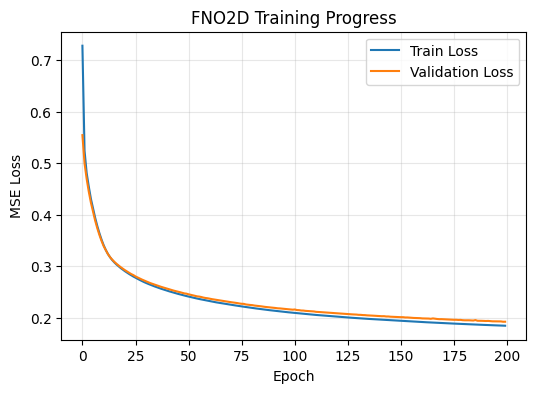

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("FNO2D Training Progress")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
import numpy as np
np.savez("loss_curves_fno2d.npz", train=np.array(loss_history), val=np.array(val_loss_history))


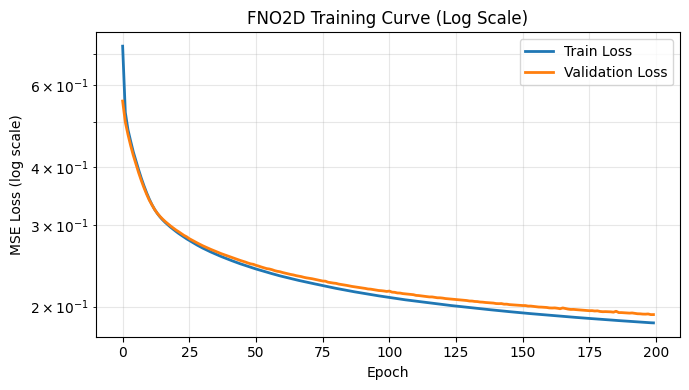

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(7, 4))
plt.plot(loss_history, label="Train Loss", lw=2)
plt.plot(val_loss_history, label="Validation Loss", lw=2)
plt.yscale("log")                      # 🔹 log-scale for y-axis
plt.xlabel("Epoch")
plt.ylabel("MSE Loss (log scale)")
plt.title("FNO2D Training Curve (Log Scale)")
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.tight_layout()
plt.show()


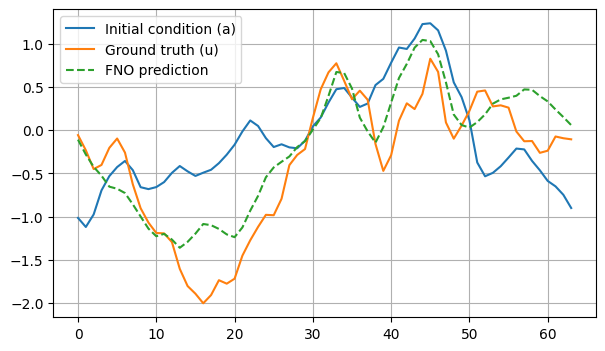

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

idx = 1
pred = fno(test_x[idx])  # (C, H, W)
mid_y = test_x.shape[-2] // 2

plt.figure(figsize=(7,4))
plt.plot(test_x[idx, 0, mid_y, :], label='Initial condition (a)')
plt.plot(test_y[idx, 0, mid_y, :], label='Ground truth (u)')
plt.plot(pred[0, mid_y, :], label='FNO prediction', linestyle='--')
plt.legend()
plt.grid(True)
plt.show()


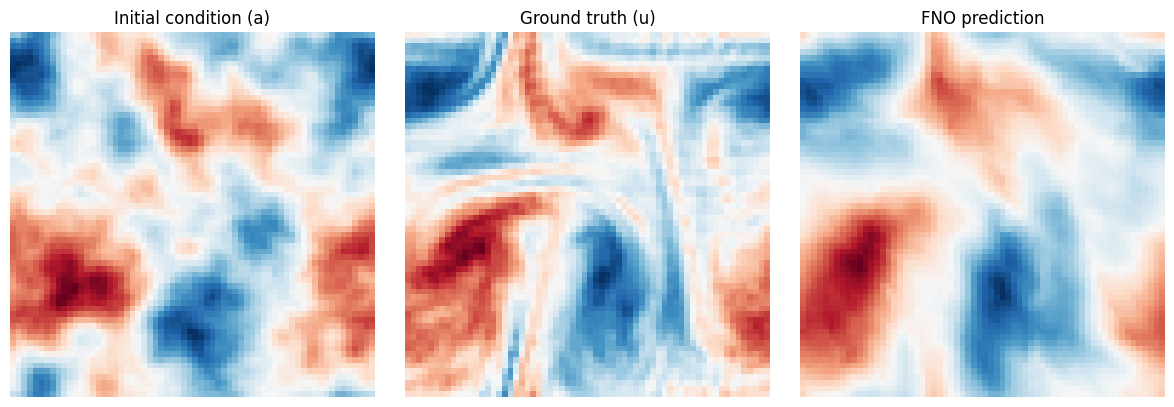

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(test_x[idx, 0], cmap='RdBu', origin='lower')
axes[0].set_title("Initial condition (a)")
axes[1].imshow(test_y[idx, 0], cmap='RdBu', origin='lower')
axes[1].set_title("Ground truth (u)")
axes[2].imshow(pred[0], cmap='RdBu', origin='lower')
axes[2].set_title("FNO prediction")
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
print("train_x mean:", train_x.mean(), "train_y mean:", train_y.mean())
print("train_x std:", train_x.std(), "train_y std:", train_y.std())

idx = 10
pred = fno(train_x[idx])
print("MSE(train_x[idx], pred):", jnp.mean((train_x[idx] - pred) ** 2))
print("MSE(train_y[idx], pred):", jnp.mean((train_y[idx] - pred) ** 2))


train_x mean: 2.597808e-10 train_y mean: -8.596544e-11
train_x std: 1.0012432 train_y std: 0.99875486
MSE(train_x[idx], pred): 0.75512564
MSE(train_y[idx], pred): 0.12404119


In [ ]:
import numpy as np
data = np.load("combined_NS_T2_samples_10k.npz")
a = data['a']    # (N,H,W)
u = data['u']

print("N:", len(a))
# Are train and test indices disjoint and not accidentally identical?
N = len(a)
train_idx = np.arange(0, int(0.8*N))
val_idx   = np.arange(int(0.8*N), N)
print("train_idx last 3:", train_idx[-3:], "val_idx first 3:", val_idx[:3])

# Very important: check that no val sample equals any train sample exactly:
overlap = False
for i in val_idx[:50]:   # check first 50 val samples (cheap)
    if any(np.all(a[i]==a[j]) and np.all(u[i]==u[j]) for j in train_idx[:200]):
        overlap = True
        break
print("Exact overlap between first val and some train? ->", overlap)


N: 10000
train_idx last 3: [7997 7998 7999] val_idx first 3: [8000 8001 8002]
Exact overlap between first val and some train? -> False


In [ ]:
# baseline: predict input a as output u (identity baseline)
val_a = a[val_idx]; val_u = u[val_idx]
mse_identity = np.mean((val_a - val_u)**2)
print("Identity baseline MSE (predict a):", mse_identity)

# baseline2: predict mean training u
mean_train_u = np.mean(u[train_idx], axis=0)
mse_mean = np.mean((val_u - mean_train_u)**2)
print("Mean-train baseline MSE:", mse_mean)


Identity baseline MSE (predict a): 0.86109453
Mean-train baseline MSE: 0.9951551


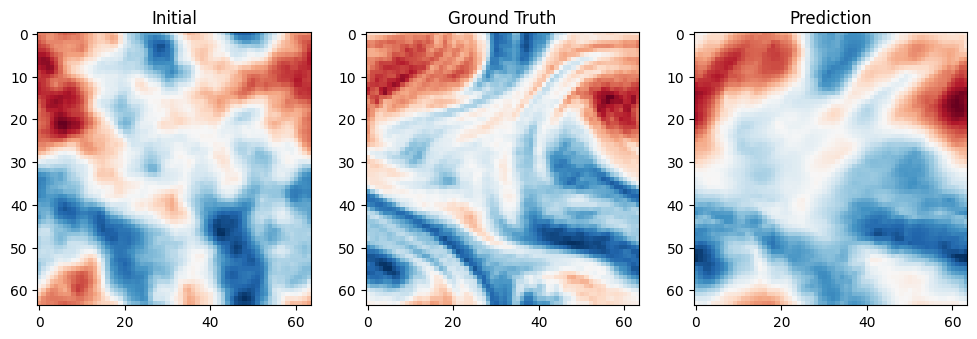

In [ ]:
idx = 15
pred = fno(test_x[idx])
fig,ax = plt.subplots(1,3,figsize=(12,4))
ax[0].imshow(test_x[idx,0], cmap='RdBu'); ax[0].set_title("Initial")
ax[1].imshow(test_y[idx,0], cmap='RdBu'); ax[1].set_title("Ground Truth")
ax[2].imshow(pred[0], cmap='RdBu'); ax[2].set_title("Prediction")
plt.show()
